# HOG

## Imports and display


Original image shape: (250, 250, 3)

Gray image shape: (250, 250)



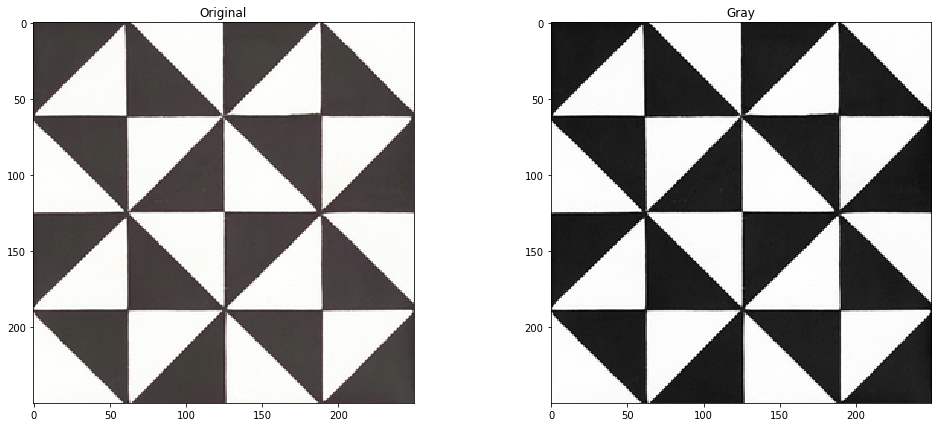

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [17, 7]

img = cv2.imread("images/triangle_tile.jpeg")

original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print("""
Original image shape: {}\n
Gray image shape: {}
""" .format(original_img.shape, gray_img.shape))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title("Original")
ax1.imshow(original_img)

ax2.set_title("Gray")
ax2.imshow(gray_img, cmap="gray");

# HOG Descriptor

The function used is going to be `cv2.HOGDescriptor()` and parms are:

`cv2.HOGDescriptor(win_size = (64, 128),
                   block_size = (16, 16),
                   block_stride = (8, 8),
                   cell_size = (8, 8),
                   nbins = 9,
                   win_sigma = DEFAULT_WIN_SIGMA,
                   threshold_L2hys = 0.2,
                   gamma_correction = true,
                   nlevels = DEFAULT_NLEVELS)`

Parameters:

* **win_size** – Size
Size of detection window in pixels (width, height). Defines the region of interest. Must be an integer multiple of cell size.

* **block_size** – Size
Block size in pixels (width, height). Defines how many cells are in each block. Must be an integer multiple of cell size and it must be smaller than the detection window. The smaller the block the finer detail you will get.

* **block_stride** – Size
Block stride in pixels (horizontal, vertical). It must be an integer multiple of cell size. The block_stride defines the distance between adjecent blocks, for example, 8 pixels horizontally and 8 pixels vertically. Longer block_strides makes the algorithm run faster (because less blocks are evaluated) but the algorithm may not perform as well.

* **cell_size** – Size
Cell size in pixels (width, height). Determines the size fo your cell. The smaller the cell the finer detail you will get.

* **nbins** – int
Number of bins for the histograms. Determines the number of angular bins used to make the histograms. With more bins you capture more gradient directions. HOG uses unsigned gradients, so the angular bins will have values between 0 and 180 degrees.

* **win_sigma** – double
Gaussian smoothing window parameter. The performance of the HOG algorithm can be improved by smoothing the pixels near the edges of the blocks by applying a Gaussian spatial window to each pixel before computing the histograms.

* **threshold_L2hys** – double
L2-Hys (Lowe-style clipped L2 norm) normalization method shrinkage. The L2-Hys method is used to normalize the blocks and it consists of an L2-norm followed by clipping and a renormalization. The clipping limits the maximum value of the descriptor vector for each block to have the value of the given threshold (0.2 by default). After the clipping the descriptor vector is renormalized as described in IJCV, 60(2):91-110, 2004.

* **gamma_correction – bool**
Flag to specify whether the gamma correction preprocessing is required or not. Performing gamma correction slightly increases the performance of the HOG algorithm.
nlevels – int
Maximum number of detection window increases.

In [3]:
# Params for HOG

# Cell size, must be smaller than the size of the detection window
# and the resulting block size must be smaller than the detection.
cell_size = (6, 6)

# Number of cells/block, the resulting block size is smaller than the detection window
num_cells_per_block = (2, 2)

# Block size must be int multiple of cell size, smaller than the detection window
block_size = (num_cells_per_block[0] * cell_size[0],
              num_cells_per_block[1] *cell_size[1])

# Calculate the number of cells that fit in image (x, y) directions
x_cells = gray_img.shape[1] // cell_size[0]
y_cells = gray_img.shape[0] // cell_size[1]

# Horizontal distance between blocks in units of cell size
#must be int and (x_cells - num_cells_per_block[0] / h_stride = int)
h_stride = 1

# Vertical distance between blocks in units of cell size, must be int and
# must (y_cells - num_cells_per_block[1] / v_stride = int)
v_stride = 1

# BLock stride (hor, vert) must be int multiple of cell size
block_stride = (cell_size[0] * h_stride, cell_size[1] * v_stride)

# Number of gradient orientation bins
num_bins = 9

# Specify the size of the detection window (Region of Interest) in pixels (width, height).
# It must be an integer multiple of Cell Size and it must cover the entire image. Because
# the detection window must be an integer multiple of cell size, depending on the size of
# your cells, the resulting detection window might be slightly smaller than the image.
# This is perfectly ok.
win_size = (x_cells * cell_size[0] , y_cells * cell_size[1])

print("""
Gray image shape: {}\n
HOG Descriptor Params:\n
Window size: {}\n
Cell size: {}\n
Block size: {}\n
Block stride: {}\n
Number of bins: {}
""" .format(gray_img.shape, win_size, cell_size, block_size, block_stride, num_bins))

# Set HOG
hog  = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

# Compute HOG for gray image
hog_descriptor = hog.compute(gray_img)


Gray image shape: (250, 250)

HOG Descriptor Params:

Window size: (246, 246)

Cell size: (6, 6)

Block size: (12, 12)

Block stride: (6, 6)

Number of bins: 9



In [5]:
# Calculate the total number of blocks along width window
tot_bx = np.uint32(((x_cells - num_cells_per_block[0]) / h_stride) + 1)

# Calculate the total number of blocks along height window
tot_by = np.uint32(((y_cells - num_cells_per_block[1]) / v_stride) + 1)

# Calculate the total number elements in feature vector
tot_els = (tot_bx) * (tot_by) * num_cells_per_block[0] * num_cells_per_block[1] * num_bins

print("""
The total number of elements in the HOG feature vector should be: \n
{} x {} x {} x {} X {} = {}
""" .format(tot_bx, tot_by, num_cells_per_block[0], num_cells_per_block[1], num_bins, tot_els))

print("\nThe HOG descriptor has shape: {}".format(hog_descriptor.shape))


The total number of elements in the HOG feature vector should be: 

40 x 40 x 2 x 2 X 9 = 57600


The HOG descriptor has shape: (57600, 1)


# Visualizing the HOG


The feature vector has shape: (57600, 1)

The reshaped feature vector has shape: (40, 40, 2, 2, 9)

Avg gradient array shape: (41, 41, 9)


<IPython.core.display.Javascript object>


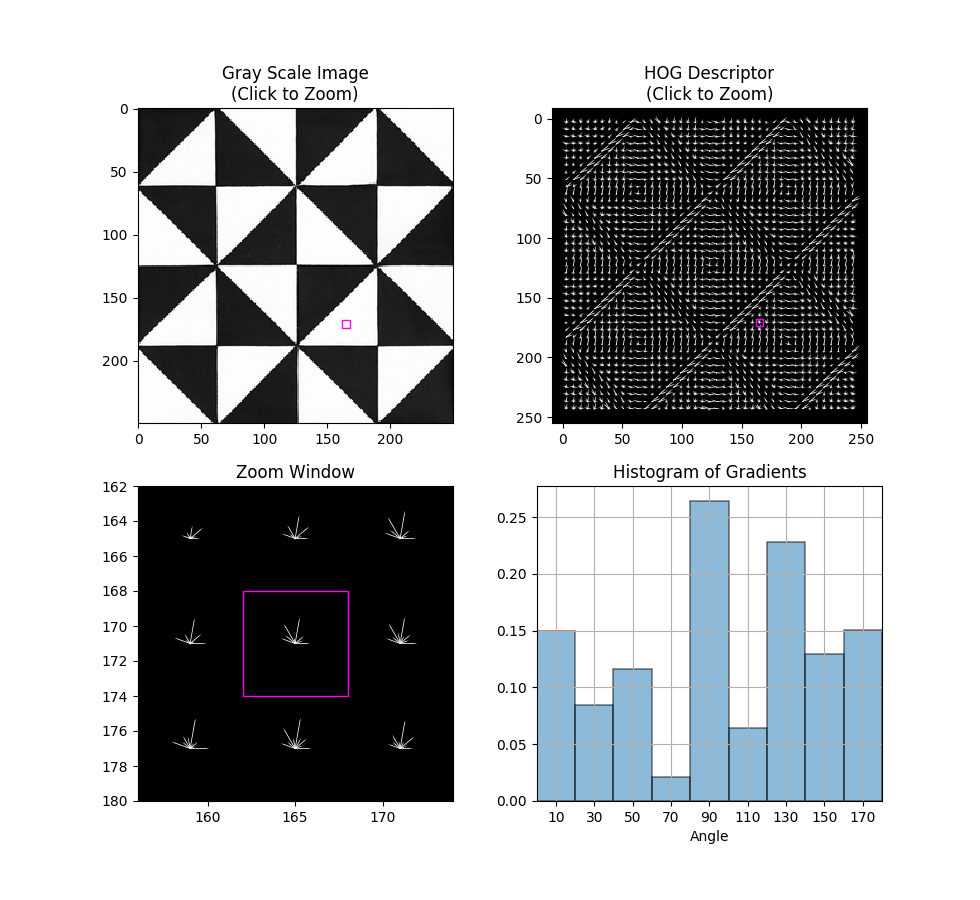

In [11]:
%matplotlib notebook

import copy
import matplotlib.patches as patches

plt.rcParams["figure.figsize"] = [9.8, 9]

# Reshape the feature vector for better work

hog_descriptor_reshaped = hog_descriptor.reshape(tot_bx,
                                                 tot_by,
                                                 num_cells_per_block[0],
                                                 num_cells_per_block[1],
                                                 num_bins).transpose((1, 0, 2, 3, 4))

print("""
The feature vector has shape: {}\n
The reshaped feature vector has shape: {}
""" .format(hog_descriptor.shape, hog_descriptor_reshaped.shape))

# Array to hold average gradients for each cell
ave_grad = np.zeros((y_cells, x_cells, num_bins))

print("Avg gradient array shape: {}" .format(ave_grad.shape))

# Array to count number of hist per cell
hist_counter = np.zeros((y_cells, x_cells, 1))

# Add up all hist for each cell and count number of hist per cell
for i in range(num_cells_per_block[0]):
    for j in range(num_cells_per_block[1]):
        ave_grad[i:tot_by + i, j:tot_bx + j] += hog_descriptor_reshaped[:, :, i, j, :]
        hist_counter[i:tot_by + i, j:tot_bx + j] += 1

# Average gradient each cell
ave_grad /= hist_counter

# Total number of vectors we have in all cells
len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]

# Array num_bins equally spaced from 0-180 in radians
deg = np.linspace(0, np.pi, num_bins, endpoint=False)

U = np.zeros((len_vecs))
V = np.zeros((len_vecs))
X = np.zeros((len_vecs))
Y = np.zeros((len_vecs))

# Set the counter to zero
counter = 0

# Use the cosine and sine functions to calculate the vector components (U,V) from their maginitudes. Remember the 
# cosine and sine functions take angles in radians. Calculate the vector positions and magnitudes from the
# average gradient array
for i in range(ave_grad.shape[0]):
    for j in range(ave_grad.shape[1]):
        for k in range(ave_grad.shape[2]):
            U[counter] = ave_grad[i,j,k] * np.cos(deg[k])
            V[counter] = ave_grad[i,j,k] * np.sin(deg[k])
        
            X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
            Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)
        
            counter = counter + 1

# Create the bins in degress to plot our histogram. 
angle_axis = np.linspace(0, 180, num_bins, endpoint = False)
angle_axis += ((angle_axis[1] - angle_axis[0]) / 2)

# Create a figure with 4 subplots arranged in 2 x 2
fig, ((a,b),(c,d)) = plt.subplots(2,2)

# Set the title of each subplot
a.set(title = 'Gray Scale Image\n(Click to Zoom)')
b.set(title = 'HOG Descriptor\n(Click to Zoom)')
c.set(title = 'Zoom Window', xlim = (0, 18), ylim = (0, 18), autoscale_on = False)
d.set(title = 'Histogram of Gradients')

# Plot the gray scale image
a.imshow(gray_img, cmap = 'gray')
a.set_aspect(aspect = 1)

# Plot the feature vector (HOG Descriptor)
b.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
b.invert_yaxis()
b.set_aspect(aspect = 1)
b.set_facecolor('black')

# Define function for interactive zoom
def onpress(event):
    
    #Unless the left mouse button is pressed do nothing
    if event.button != 1:
        return
    
    # Only accept clicks for subplots a and b
    if event.inaxes in [a, b]:
        
        # Get mouse click coordinates
        x, y = event.xdata, event.ydata
        
        # Select the cell closest to the mouse click coordinates
        cell_num_x = np.uint32(x / cell_size[0])
        cell_num_y = np.uint32(y / cell_size[1])
        
        # Set the edge coordinates of the rectangle patch
        edgex = x - (x % cell_size[0])
        edgey = y - (y % cell_size[1])
        
        # Create a rectangle patch that matches the the cell selected above        
        rect = patches.Rectangle((edgex, edgey),
                                  cell_size[0], cell_size[1],
                                  linewidth = 1,
                                  edgecolor = 'magenta',
                                  facecolor='none')
        
        # A single patch can only be used in a single plot. Create copies
        # of the patch to use in the other subplots
        rect2 = copy.copy(rect)
        rect3 = copy.copy(rect)
        
        # Update all subplots
        a.clear()
        a.set(title = 'Gray Scale Image\n(Click to Zoom)')
        a.imshow(gray_img, cmap = 'gray')
        a.set_aspect(aspect = 1)
        a.add_patch(rect)

        b.clear()
        b.set(title = 'HOG Descriptor\n(Click to Zoom)')
        b.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
        b.invert_yaxis()
        b.set_aspect(aspect = 1)
        b.set_facecolor('black')
        b.add_patch(rect2)

        c.clear()
        c.set(title = 'Zoom Window')
        c.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 1)
        c.set_xlim(edgex - cell_size[0], edgex + (2 * cell_size[0]))
        c.set_ylim(edgey - cell_size[1], edgey + (2 * cell_size[1]))
        c.invert_yaxis()
        c.set_aspect(aspect = 1)
        c.set_facecolor('black')
        c.add_patch(rect3)

        d.clear()
        d.set(title = 'Histogram of Gradients')
        d.grid()
        d.set_xlim(0, 180)
        d.set_xticks(angle_axis)
        d.set_xlabel('Angle')
        d.bar(angle_axis,
              ave_grad[cell_num_y, cell_num_x, :],
              180 // num_bins,
              align = 'center',
              alpha = 0.5,
              linewidth = 1.2,
              edgecolor = 'k')

        fig.canvas.draw()

# Create a connection between the figure and the mouse click
fig.canvas.mpl_connect('button_press_event', onpress)
plt.show()